# Python Basics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import datetime



In [2]:


csvFileAddress = 'csv/WTI_M20_202102010100_202301272340.csv'


DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<VOL>'],axis=1,inplace=True)



In [3]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [4]:
timeFrame

20

In [5]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newnumparr = np.full((uniqueDaysCount*CandlesInDay,2),'',dtype=np.object_)


for i in range(uniqueDaysCount):
    for j in range(CandlesInDay):
        newnumparr[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]

newDF = pd.DataFrame(newnumparr,columns=['<DATE>','<TIME>'])


In [6]:

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

# newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x'],inplace=True)
newestDF.fillna(0,inplace=True)

newestDF['<EMA30>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=30)
newestDF['<EMA50>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=50)
newestDF['<EMA200>']= ta.trend.ema_indicator( newestDF['<CLOSE>'],window=200)

def Upper(e):
    if e['<ISGREEN>'] : 
        return e['<HIGH>']-e['<CLOSE>']
    return e['<HIGH>']-e['<OPEN>']

def Lower(e):
    if e['<ISGREEN>'] : 
        return e['<OPEN>']-e['<LOW>']
    return e['<CLOSE>']-e['<LOW>']


newestDF['<UPPER>'] = newestDF.apply(Upper,axis=1)
newestDF['<LOWER>'] = newestDF.apply(Lower,axis=1)




In [7]:
# Compute RSI

newestDF['<RSI>'] = ta.momentum.rsi(newestDF['<CLOSE>'],window=15) / 100
newestDF['<CCI>'] = ta.trend.cci(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=14)


keltner = ta.volatility.KeltnerChannel(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=20,window_atr=10,multiplier=2.5)
newestDF['<KELTNER_H>'] = keltner.keltner_channel_hband()
newestDF['<KELTNER_L>'] = keltner.keltner_channel_lband()
newestDF['<KELTNER_M>'] = keltner.keltner_channel_mband()


newestDF['<ATR_24>'] = ta.volatility.average_true_range(close=newestDF['<CLOSE>'],high=newestDF['<HIGH>'],low=newestDF['<LOW>'],window=12).apply(lambda e : e/100)


newestDF["<GREEN>"] = newestDF["<ISGREEN>"].astype(int)




# (newestDF,open="<OPEN>",close='<CLOSE>',high='<HIGH>',low='<LOW>',volume='<TICKVOL>',)

In [8]:
newestDF

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<SPREAD>,<ISGREEN>,<SIZE>,...,<EMA200>,<UPPER>,<LOWER>,<RSI>,<CCI>,<KELTNER_H>,<KELTNER_L>,<KELTNER_M>,<ATR_24>,<GREEN>
0,2021.02.01,00:00:00,0.00,0.00,0.00,0.00,0.0,0.0,0,0.00,...,NaN,0.00,0.00,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
1,2021.02.01,00:20:00,0.00,0.00,0.00,0.00,0.0,0.0,0,0.00,...,NaN,0.00,0.00,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
2,2021.02.01,00:40:00,0.00,0.00,0.00,0.00,0.0,0.0,0,0.00,...,NaN,0.00,0.00,NaN,NaN,0.000000,0.000000,NaN,0.000000,0
3,2021.02.01,01:00:00,51.98,52.07,51.58,51.70,398.0,2.0,False,-0.28,...,NaN,0.09,0.12,NaN,NaN,13.068333,12.823333,NaN,0.000000,0
4,2021.02.01,01:20:00,51.69,51.87,51.67,51.86,172.0,4.0,True,0.17,...,NaN,0.01,0.02,NaN,NaN,20.854667,20.578667,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2023.01.27,22:20:00,79.66,79.68,79.53,79.55,239.0,1.0,False,-0.11,...,78.585988,0.02,0.02,0.398503,-50.904598,80.901167,79.846167,80.373667,0.004485,0
37076,2023.01.27,22:40:00,79.54,79.59,79.45,79.53,263.0,1.0,False,-0.01,...,78.595381,0.05,0.08,0.396509,-65.685302,80.734833,79.737833,80.236333,0.004228,0
37077,2023.01.27,23:00:00,79.51,79.57,79.48,79.52,114.0,3.0,True,0.01,...,78.604581,0.05,0.03,0.395450,-67.236332,80.580833,79.640833,80.110833,0.003950,1
37078,2023.01.27,23:20:00,79.53,79.56,79.48,79.50,61.0,3.0,False,-0.03,...,78.613491,0.03,0.02,0.393198,-78.748825,80.452000,79.546000,79.999000,0.003688,0


In [9]:
list = []
for i in range(len(newestDF)):
    
    date = newestDF.iloc[i]["<DATE>"]
    time = newestDF.iloc[i]["<TIME>"]
    isGreen = newestDF.iloc[i]["<ISGREEN>"]
    size = newestDF.iloc[i]["<SIZE>"]
    low = newestDF.iloc[i]["<LOW>"]
    high = newestDF.iloc[i]["<HIGH>"]
    volatility = newestDF.iloc[i]["<VOLATILITY>"]
    atr = newestDF.iloc[i]['<ATR_24>']
    
    list.append([date, time, isGreen, size,low,high, volatility,atr])


In [10]:
days = []
daysDfs = []
for i in range(uniqueDaysCount): 
    daysDfs.append(pd.DataFrame(list[i*CandlesInDay: CandlesInDay*(i+1)],columns=[
        'date',
'time',
'isGreen',
'size',
'low',
'high',
'volatility',
'atr',
    ]))
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [25]:

maxList=np.zeros(CandlesInDay)
minList=np.zeros(CandlesInDay)
volatList=np.zeros(CandlesInDay)


for i in (daysDfs):

    sth = i.loc[~((i['low'] == 0))]
    
    
    minList[(sth['size'].idxmin())]+=1
    maxList[(sth['size'].idxmax())]+=1
    volatList[(sth['volatility'].idxmax())]+=1



In [26]:
sth.head(300)

,date,time,isGreen,size,low,high,volatility,atr
3,2023.01.27,01:00:00,True,0.11,81.15,81.28,0.13,0.122117
4,2023.01.27,01:20:00,False,-0.03,81.18,81.26,0.08,0.112007
5,2023.01.27,01:40:00,False,-0.02,81.16,81.24,0.08,0.102740
6,2023.01.27,02:00:00,True,0.03,81.15,81.26,0.11,0.094270
7,2023.01.27,02:20:00,True,0.01,81.23,81.29,0.06,0.086464
...,...,...,...,...,...,...,...,...
67,2023.01.27,22:20:00,False,-0.11,79.53,79.68,0.15,0.004485
68,2023.01.27,22:40:00,False,-0.01,79.45,79.59,0.14,0.004228
69,2023.01.27,23:00:00,True,0.01,79.48,79.57,0.09,0.003950
70,2023.01.27,23:20:00,False,-0.03,79.48,79.56,0.08,0.003688


50.0

<BarContainer object of 70 artists>

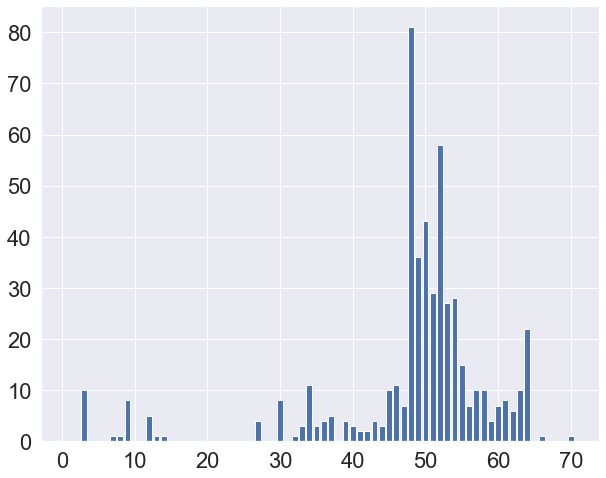

In [34]:
plt.figure(figsize=(10,8))

plt.bar(x=range(CandlesInDay)[1:-1],height=volatList[1:-1])


<BarContainer object of 70 artists>

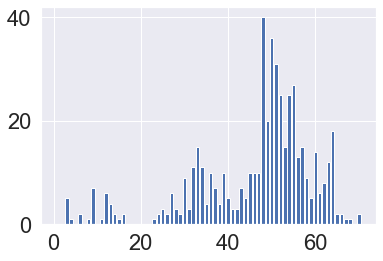

In [35]:
plt.bar(x=range(CandlesInDay)[1:-1],height=minList[1:-1])



<BarContainer object of 70 artists>

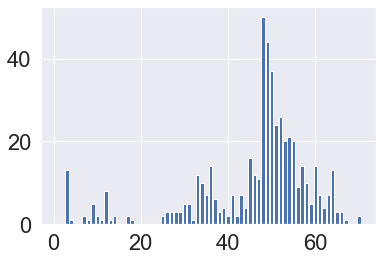

In [30]:
plt.bar(x=range(CandlesInDay)[1:-1],height=maxList[1:-1])

<BarContainer object of 70 artists>

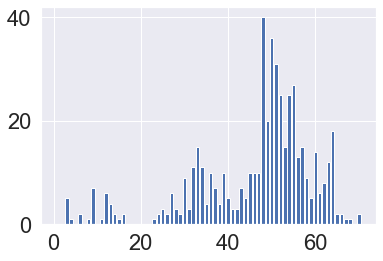

In [31]:
plt.bar(x=range(CandlesInDay)[1:-1],height=minList[1:-1])

In [18]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][6])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            # if abs(day[i][3])> avgCandleBodySize*avgMultiplier and abs(day[j][3])>0 : #SIZE
            if abs(day[i][6])> avgCandleVolatility*avgMultiplier and abs(day[j][6])>0 : #VOLATILITY
            # if abs(day[i][3]) > (day[i][5]*avgMultiplier) and abs(day[j][4])>0 : #ATR
                countMatrix[i][j] += 1
                if not(day[i][2] ^ day[j][2]):
                    ansMatrix[i][j]=1 
                else:
                    ansMatrix[i][j]=-1
                    
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    [ansVectorDay,countVectorDay] = eachDayMatrix(days[i])
    countVector.append(countVectorDay)
    ansVector.append(ansVectorDay)

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

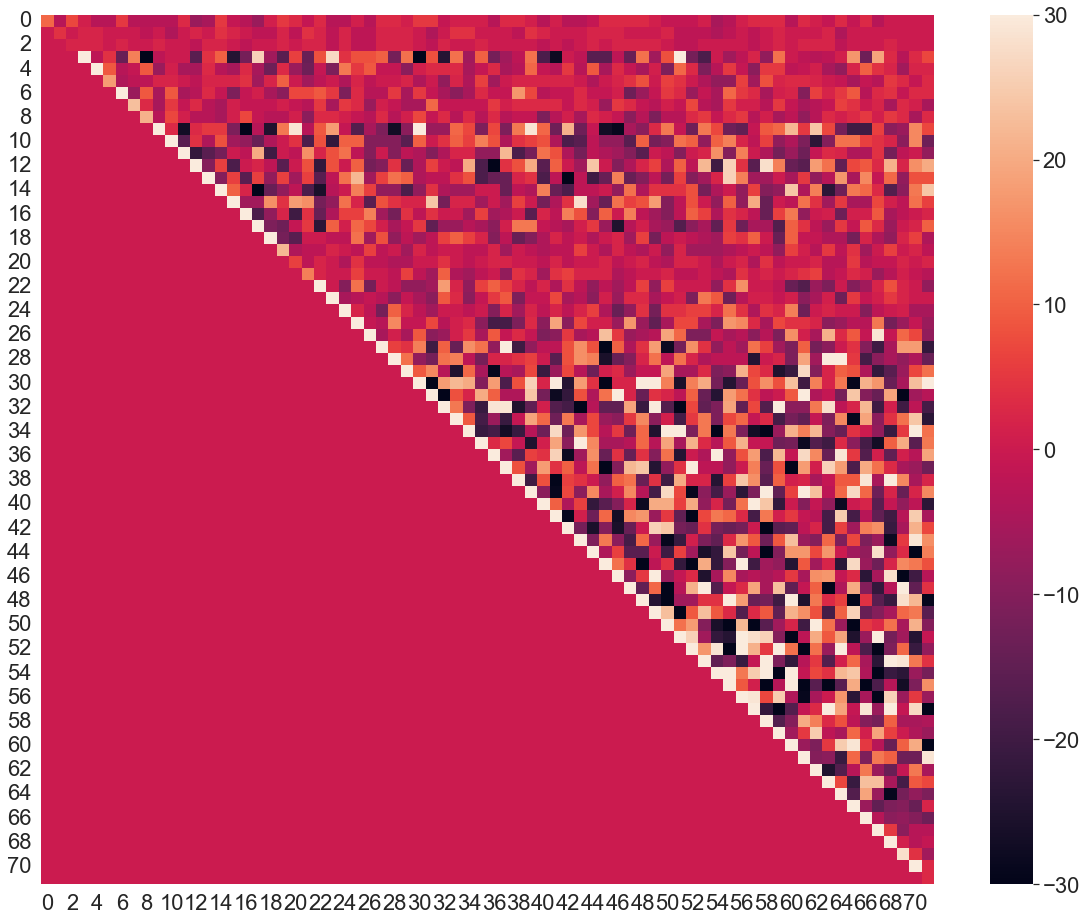

In [19]:
plt.figure(figsize=(20,16))
sns.set(font_scale=2)
sns.heatmap(final,vmax=30,vmin=-30,annot=False)



<AxesSubplot:>

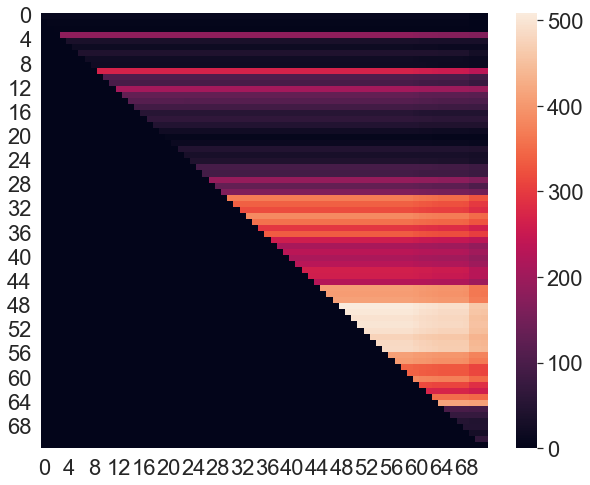

In [20]:
plt.figure(figsize=(10,8))

sns.heatmap(countFinal,annot=False,)


In [21]:
# float(input('Bias:')) 
biasPercentage = 65



consecutiveAndClose = 1
consecutiveOnly = 0

percentTimesCountedAtLeastMoreThan = 20

print(uniqueDaysCount,'Days ; ','Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Consecutive')
                continue

            if(j-i <= 120/timeFrame) and (not consecutiveOnly):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Close') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Close')
                continue

            if not(consecutiveAndClose or consecutiveOnly): 
                
                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg)




515 Days ;  Averages Multiplier : 1.0
3-8 01:00:00-02:40:00 67.58% -- 35.33 Close
10-11 03:20:00-03:40:00 65.09% -- 20.58 Consecutive
14-17 04:40:00-05:40:00 83.33% -- 22.13 Close
29-33 09:40:00-11:00:00 65.33% -- 31.65 Close
38-41 12:40:00-13:40:00 66.98% -- 41.16 Close


In [22]:
uniqueDaysCount

515